In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots 
import statsmodels.api as sm
import pmdarima as pm

## Data prepocessing

We load the data. Assing the date to index. Parse the date format to year-month.day. Convert the strings to numeric format

In [2]:
data = pd.read_csv('./data/USD_CNY.csv')
index_date = data.Fecha.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))
index_date = index_date.apply(lambda x: x.strftime('%Y-%m-%d'))

data.index = pd.to_datetime(index_date)
data = data.drop('Fecha', axis='columns')
data = data.apply(lambda x: x.str.replace(',','.'))
data = data.apply(lambda x: x.str.replace('%',''))
data = data.astype(np.float)
data.head()

,Último,Apertura,Máximo,Mínimo,% var.
Fecha,,,,,
2020-03-17,7.0079,6.9951,7.0249,6.9869,0.21
2020-03-16,6.9934,7.0016,7.0251,6.9896,-0.22
2020-03-13,7.0086,7.0299,7.0379,6.9773,-0.30
2020-03-12,7.0294,6.9611,7.0373,6.9611,0.99
2020-03-11,6.9605,6.9584,6.9656,6.9442,0.06


In [3]:
data.tail()

,Último,Apertura,Máximo,Mínimo,% var.
Fecha,,,,,
2019-08-23,7.0960,7.0893,7.1018,7.0731,0.18
2019-08-22,7.0836,7.0601,7.0940,7.0601,0.29
2019-08-21,7.0632,7.0594,7.0668,7.0499,0.04
2019-08-20,7.0605,7.0495,7.0686,7.0495,0.14
2019-08-19,7.0507,7.0386,7.0514,7.0381,0.11


## Visualization

We plotted the data and spanned the time range where COVID19 first appeared.

El rotativo afirma que una persona de 55 años natural de la provincia de Hubei, foco del brote, habría sido la primera en contagiarse con el virus. Según el diario, que asegura haber tenido acceso a los datos gubernamentales, desde entonces sumaron de uno a cinco contagios cada día; para el 15 de diciembre, el número total de infecciones era de 27, y el 20 de diciembre había ya 60 contagiados. 

https://www.eltiempo.com/mundo/asia/primer-contagio-de-covid-19-en-china-fue-en-noviembre-segun-prensa-472466

Text(0, 0.5, 'USD/CNY')

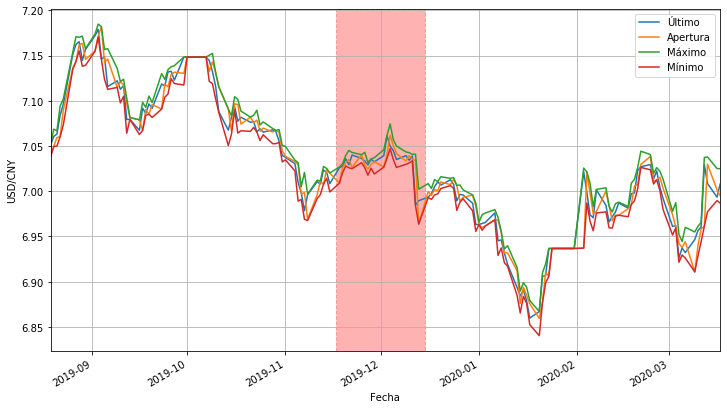

In [4]:
data = data.drop('% var.', axis=1)
ax = data.plot(grid=True, figsize=(12,7))
ax.axvspan('2019-11-17', '2019-12-15',color='red', linestyle='--', alpha=0.3)
ax.set_ylabel('USD/CNY')

A look at the above figure, shows that the time series is not stationary. Also, we noted that the all features of the time series follows the same behavior so we just will use the opening values of the data. 

## STATIONARITY

Although the previous plot shows that the TS is not stationary, the visual inspection is not enough to determite if the series is stationary, so we will apply Dickey-Fuller Test.

This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary


In [5]:
def test_stationarity(timeseries, window=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
    
    ax1.set_title('Rolling Mean & Standard Deviation',fontsize=20)
    timeseries.plot(ax=ax1, color='blue',label='Original',figsize=(12, 10) )
    rolmean.plot(ax=ax1, color='red', label='Rolling Mean')
    ax1.legend(['or','mean'],loc='best')
    rolstd.plot(ax=ax2, color='black', label = 'Rolling Std')
    ax2.legend()
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

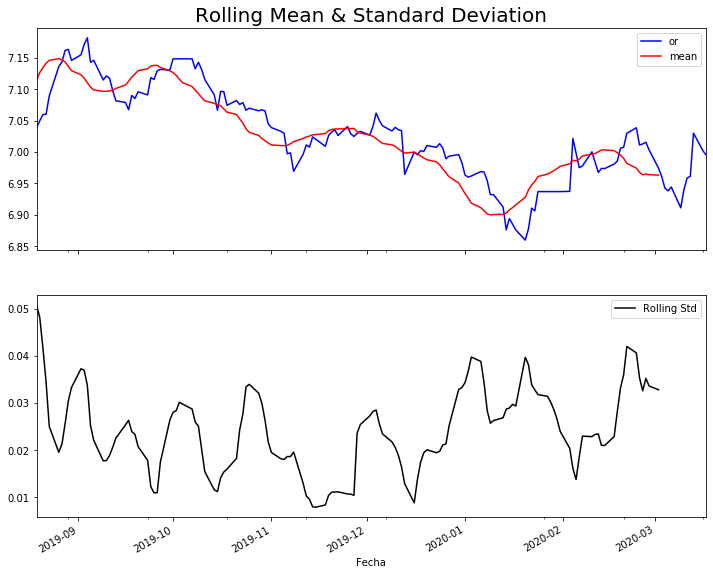

Results of Dickey-Fuller Test:
Test Statistic                  -1.596954
p-value                          0.485123
#Lags Used                       0.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


In [6]:
test_stationarity(data.Apertura)

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values.

## Normalization

We can consider whether normalizing data can make data from different time periods comparable. Let’s take a look at a month’s worth of scaled opening prices for fuorth different month within the time series

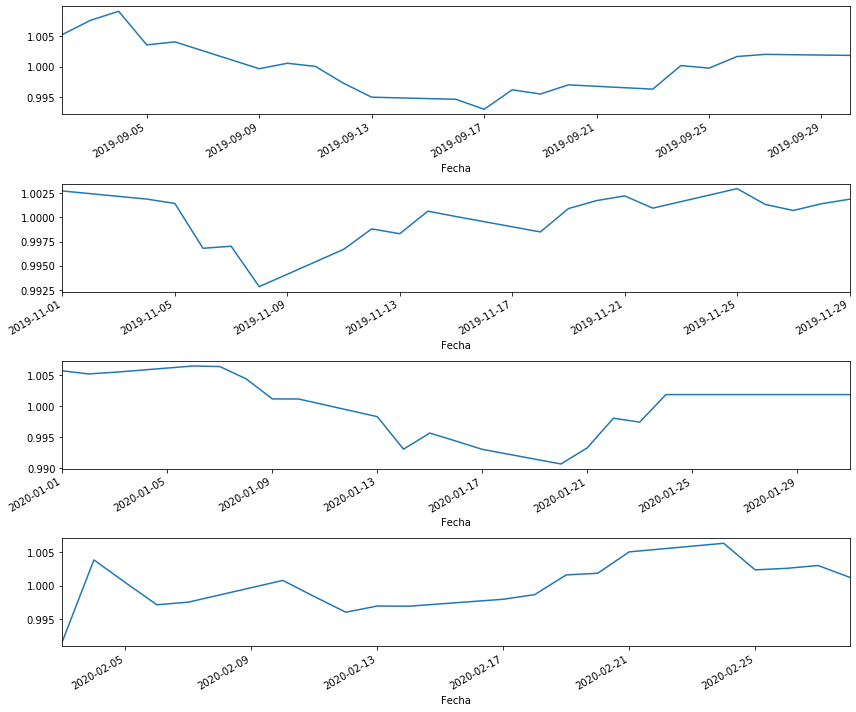

In [7]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1)
vals1 = data['2019-09'].Apertura/data['2019-09'].Apertura.mean()
mean_vals1 = np.mean(vals1)
vals1.plot(figsize=(12, 10),ax=ax1)

vals2 = data['2019-11'].Apertura/data['2019-11'].Apertura.mean()
mean_vals2 = np.mean(vals2)
vals2.plot(figsize=(12, 10),ax=ax2)

vals3 = data['2020-01'].Apertura/data['2020-01'].Apertura.mean()
mean_vals3 = np.mean(vals3)
vals3.plot(figsize=(12, 10),ax=ax3)

vals4 = data['2020-02'].Apertura/data['2020-02'].Apertura.mean()
mean_vals4 = np.mean(vals4)
vals4.plot(figsize=(12, 10),ax=ax4)

plt.tight_layout()

The relative percentage changes from day to day in the course of a month seem about the same across the years.
These plots are promising. While the mean values and variance of the opening prices have changed substantially over time, the plots suggest similar behavior over time once we normalize the data to its mean value for a given decade.

## Eliminating Trend and Seasonality

First, we will resample the series by week beacause that is a popular Strategy Using Autocorrelation. That means, following large jumps, either up or down, stock prices tend to reverse. This is described as mean reversion in stock prices: prices tend to bounce back, or revert, towards previous levels after large moves, which are observed over time horizons of about a week. This simple idea is actually the basis for a popular hedge fund strategy.

After, we apply differencing which is one of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. Then, we apply adfuller again to corroborate that the serie is stationary. 

https://www.quantopian.com/posts/enhancing-short-term-mean-reversion-strategies-1

,Último,Apertura,Máximo,Mínimo
Fecha,,,,
2019-09-01,0.012055,0.012851,0.012458,0.012478
2019-09-08,-0.000537,0.001292,0.000871,-0.000104
2019-09-15,-0.007016,-0.007386,-0.008074,-0.006901
2019-09-22,-0.002163,-0.003245,-0.002587,-0.002264
2019-09-29,0.005325,0.004746,0.005387,0.004666
2019-10-06,0.003355,0.003889,0.002167,0.004645
2019-10-13,-0.003139,-0.001481,-0.001223,-0.003705
2019-10-20,-0.006382,-0.006922,-0.006409,-0.006864
2019-10-27,-0.001381,-0.001454,-0.001799,-0.000382


Text(0, 0.5, 'USD/CNY %var semanal')

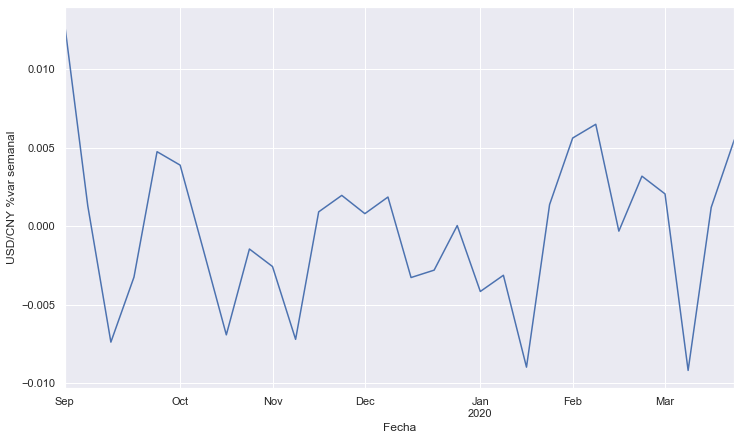

In [8]:
sns.set()
plt.figure(figsize=(12,7))
data_week = data.resample(rule='W').mean()
data_week_pct = data_week.pct_change()
data_week_pct.drop(data_week_pct.index[:1], inplace=True)
display(data_week_pct)
ax1 = data_week_pct['Apertura'].plot(grid=True)
ax1.set_ylabel('USD/CNY %var semanal')

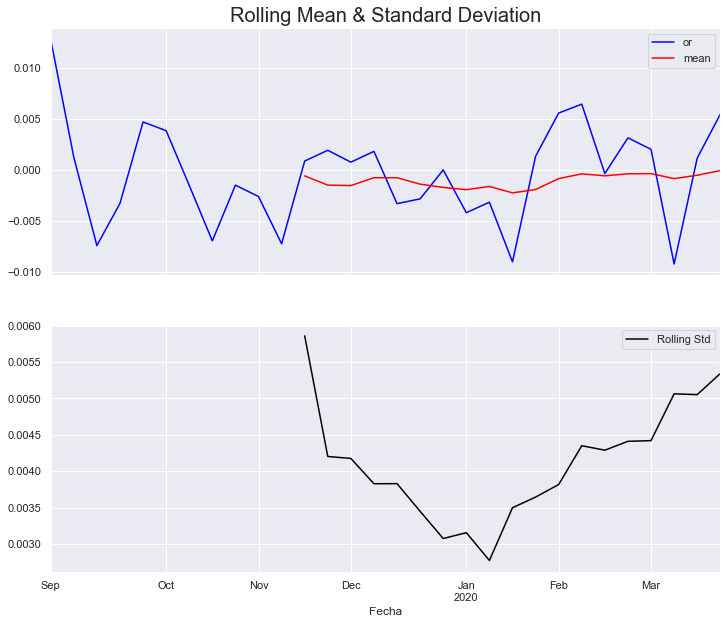

Results of Dickey-Fuller Test:
Test Statistic                 -4.953217
p-value                         0.000027
#Lags Used                      0.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


In [9]:
test_stationarity(data_week_pct.Apertura, 6)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series.

## SEASONAL DESCOMPOSITION

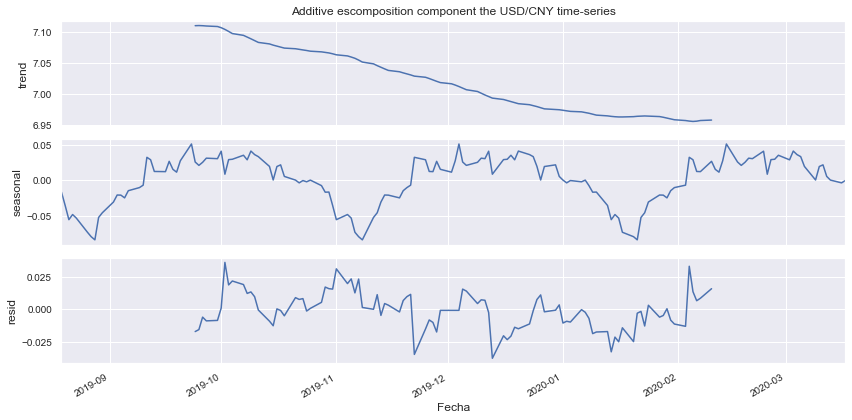

In [10]:
decomposition_Apertura = sm.tsa.seasonal_decompose(data['Apertura'],period = 52, model='additive')
seasonal = decomposition_Apertura.seasonal
trend = decomposition_Apertura.trend
resid = decomposition_Apertura.resid

sns.set()
f, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
trend.plot(figsize=(12, 6), fontsize=10, ax=ax1)
ax1.set_ylabel('trend', fontsize=12)
ax1.set_title('Additive escomposition component the USD/CNY time-series', fontsize=12)
seasonal.plot(figsize=(12, 6), fontsize=10, ax=ax2)
ax2.set_ylabel('seasonal', fontsize=12)
resid.plot(figsize=(12, 6), fontsize=10, ax=ax3)
ax3.set_ylabel('resid', fontsize=12)
plt.tight_layout()

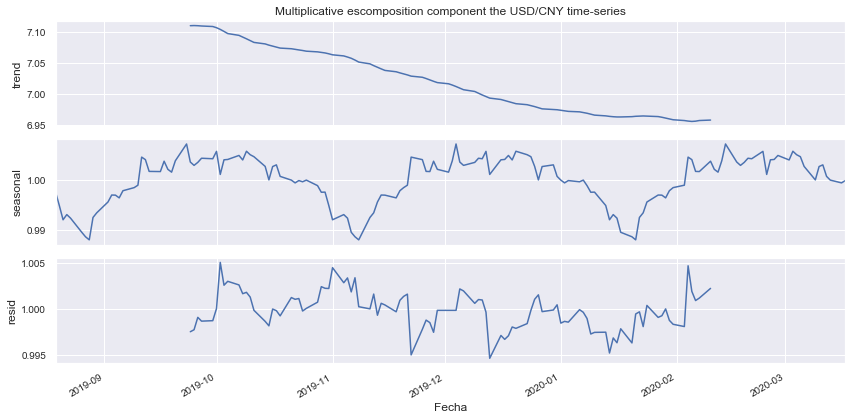

In [11]:
decomposition_Apertura = sm.tsa.seasonal_decompose(data['Apertura'],period = 52, model='multiplicative')
seasonal = decomposition_Apertura.seasonal
trend = decomposition_Apertura.trend
resid = decomposition_Apertura.resid

sns.set()
f, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
trend.plot(figsize=(12, 6), fontsize=10, ax=ax1)
ax1.set_ylabel('trend', fontsize=12)
ax1.set_title('Multiplicative escomposition component the USD/CNY time-series', fontsize=12)
seasonal.plot(figsize=(12, 6), fontsize=10, ax=ax2)
ax2.set_ylabel('seasonal', fontsize=12)
resid.plot(figsize=(12, 6), fontsize=10, ax=ax3)
ax3.set_ylabel('resid', fontsize=12)
plt.tight_layout()

with the previous plots, we see that there are a seasonal component that represent a periodic movement each two months. Also, we a decaying tend in the serie. 

## Forescating

A popular and widely used statistical method for time series forecasting is the ARIMA model.
ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data

The parameters of the ARIMA model are defined as follows:

    p(Number of AR order) : The number of lag observations included in the model, also called the lag order.
    d: The number of times that the raw observations are differenced, also called the degree of differencing.
    q(Number of MA order): The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary

<Figure size 1440x720 with 0 Axes>

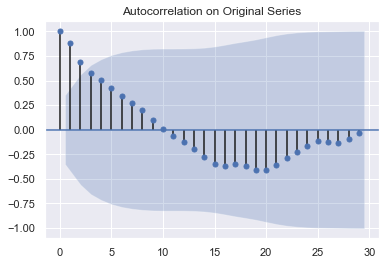

In [12]:
sns.set()
fig = plt.figure(figsize=(20, 10))
fig = tsaplots.plot_acf(data_week['Apertura'], lags=29, title="Autocorrelation on Original Series")

we can see that there is a positive correlation with the first 10 lags that is perhaps significant for the first 2 lags. A good starting point for the AR parameter of the model may be 2.

c:\users\gabriela\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


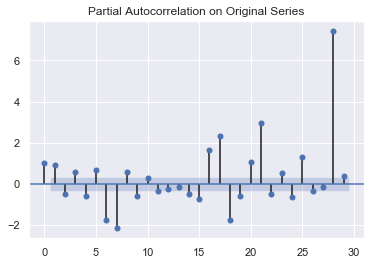

In [13]:
fig = tsaplots.plot_pacf(data_week['Apertura'], lags=29, title="Partial Autocorrelation on Original Series")

we can see that there are significant correlations for all lags.

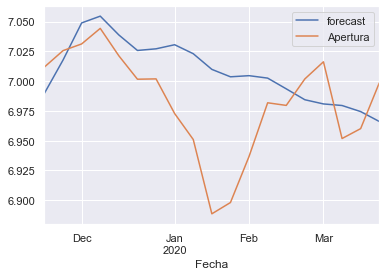

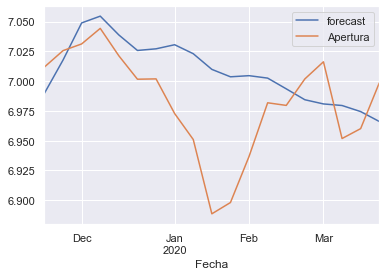

In [21]:
model = ARIMA(data_week.Apertura, order=(4, 1, 5))
results = model.fit()
results.plot_predict('2019-11-17', dynamic=True, alpha=0.05)

In [22]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.Apertura   No. Observations:                   30
Model:                 ARIMA(4, 1, 5)   Log Likelihood                  63.541
Method:                       css-mle   S.D. of innovations              0.027
Date:                Sat, 18 Apr 2020   AIC                           -105.082
Time:                        20:33:09   BIC                            -89.669
Sample:                    09-01-2019   HQIC                          -100.151
                         - 03-22-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0052      0.002     -3.036      0.002      -0.009      -0.002
ar.L1.D.Apertura     0.9076      0.895      1.014      0.311      -0.848       2.663
ar.L2.D.Apertura    -1.1409      0.913     -1.249      0.212      -2.931       0.649
ar.L3.D.Apertura     0.4848      1.026      0.472      0.637      -1.527       2.496
ar.L4.D.Apertura    -0.1028      0.504     -0.204      0.838      -1.091       0.886
ma.L1.D.Apertura    -0.8144      0.883     -0.923      0.356      -2.544       0.915
ma.L2.D.Apertura     0.5208      0.879      0.593      0.553      -1.201       2.243
ma.L3.D.Apertura    -0.0275      0.620     -0.044      0.965      -1.243       1.189
ma.L4.D.Apertura    -0.5050      0.366     -1.378      0.168      -1.223       0.213
ma.L5.D.Apertura    -0.1740      0.620     -0.281      0.779      -1.389       1.041
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2271           -1.0836j            1.1071           -0.2171
AR.2            0.2271           +1.0836j            1.1071            0.2171
AR.3            2.1302           -1.8426j            2.8165           -0.1135
AR.4            2.1302           +1.8426j            2.8165            0.1135
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            0.2986           -0.9544j            1.0000           -0.2017
MA.3            0.2986           +0.9544j            1.0000            0.2017
MA.4           -2.2498           -0.8282j            2.3974           -0.4439
MA.5           -2.2498           +0.8282j            2.3974            0.4439
-----------------------------------------------------------------------------
"""

## Auto Arima

In [23]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=True,
                              trace=True)
    return automodel

def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="d")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show()

Performing stepwise search to minimize aic


c:\users\gabriela\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-420.420, BIC=-410.603, Time=0.457 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-422.842, BIC=-417.934, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-422.316, BIC=-414.952, Time=0.083 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-422.417, BIC=-415.053, Time=0.112 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-424.837, BIC=-422.383, Time=0.079 seconds
Total fit time: 0.778 seconds


c:\users\gabriela\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


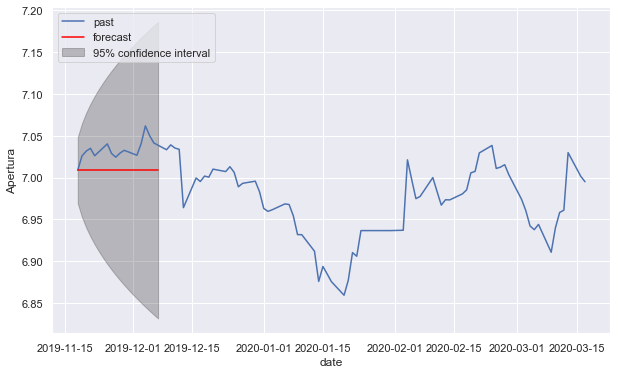

In [24]:
automodel = arimamodel(data[:'2019-11-17'].Apertura)
plotarima(20, data[:'2019-11-17'].Apertura, automodel)

C:\Users\GABRIELA\AppData\Roaming\Python\Python36\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 152, using nperseg = 152
  .format(nperseg, input_length))


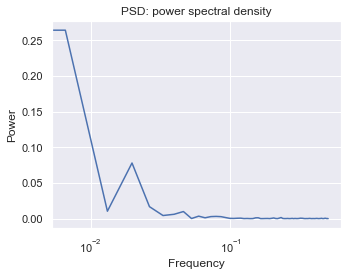

In [25]:
from scipy import signal
freqs, psd = signal.welch(data.Apertura.values)

plt.figure(figsize=(5, 4))
plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()
